# NPLM Output Analysis

## Imports

In [2]:
import torch 
import h5py
import os 
import sys 
import json

import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

sys.path.insert(0, "../src")
from plot_utils     import plot_ref_data, plot_ref_data_reco, plot_loss_history, plot_one_t, plot_two_t, plot_quantiles_evolution
from analysis_utils import compute_df, produce_bins, save_binning, load_binning, find_results, load_results, compute_t_from_loss
from nn_utils       import NPLMnetwork

## Config

In [3]:
hep.style.use(hep.style.CMS)

## Constants

In [4]:
OUTPUT_DIRECTORY = "../output/test/"

# Plotting parameters
FONTSIZE  = 36
FIGSIZE_R = (14, 12)
FIGSIZE   = (14, 10)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

## Config JSONs

In [5]:
#w_clip = 5
# json_path_ref  = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_5.0_Arch_1_4_1/2024_1_29_8_36_20_97375/config_2024_1_29_8_36_20_97375.json"
# json_path_data = "/home/ubuntu/NPLM.torch/output/test/wclip_test1/NRef_200000_NBkg_2000_NSig_10_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_5.0_Arch_1_4_1/2024_1_26_17_18_52_646186/config_2024_1_26_17_18_52_646186.json"

# w_clip = 10
# json_path_ref  = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_10.0_Arch_1_4_1/2024_1_29_9_32_25_964095/config_2024_1_29_9_32_25_964095.json"
# json_path_data = "/home/ubuntu/NPLM.torch/output/test/wclip_test1/NRef_200000_NBkg_2000_NSig_10_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_10.0_Arch_1_4_1/2024_1_26_18_15_19_94417/config_2024_1_26_18_15_19_94417.json"

# w_clip = 15 
# json_path_ref = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_15.0_Arch_1_4_1/2024_1_29_10_27_47_707642/config_2024_1_29_10_27_47_707642.json"

# w_clip = 20
# json_path_ref = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_20.0_Arch_1_4_1/2024_1_29_11_23_28_784271/config_2024_1_29_11_23_28_784271.json"

# w_clip = 25
# json_path_ref = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_25.0_Arch_1_4_1/2024_1_29_12_17_58_775129/config_2024_1_29_12_17_58_775129.json"

# w_clip = 30
# json_path_ref = "/home/ubuntu/NPLM.torch/output/test/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_30.0_Arch_1_4_1/2024_1_29_13_12_3_730011/config_2024_1_29_13_12_3_730011.json"


# with open(json_path_ref) as f:
#     config_json_ref = json.load(f)
# config_json_ref

In [103]:
# json_path_ref =  '/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.3_Arch_1_4_1/2024_1_31_20_56_32_456955/config_2024_1_31_20_56_32_456955.json'
# json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/second/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.0_Arch_1_4_1/2024_1_30_7_51_27_372767/config_2024_1_30_7_51_27_372767.json"
json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.1_Arch_1_4_1/2024_1_31_14_29_9_634113/config_2024_1_31_14_29_9_634113.json"
# json_path_ref = "/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.8_Arch_1_4_1/2024_1_31_20_36_48_921900/config_2024_1_31_20_36_48_921900.json"

with open(json_path_ref) as f:
    config_json_ref = json.load(f)
config_json_ref

{'N_Ref': 200000,
 'N_Bkg': 2000,
 'N_Sig': 0,
 'SIG_LOC': 6.4,
 'SIG_STD': 0.16,
 'output_directory': '../output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.1_Arch_1_4_1/2024_1_31_14_29_9_634113/',
 'input_directory': './',
 'epochs': 200000,
 'patience': 5000,
 'architecture': [1, 4, 1],
 'weight_clipping': 7.1,
 'date': '2024_1_31_14_29_9_634113',
 'pyscript': 'toy.py',
 'toys': 50}

## Load NPLM results

In [104]:
ref_dir  = config_json_ref["output_directory"]
# data_dir = config_json_data["output_directory"]

ref_losses_names   = find_results(ref_dir, "losses.pth")
ref_weights_names  = find_results(ref_dir, "weights.pth")
# data_losses_names  = find_results(data_dir, "losses.pth")
# data_weights_names = find_results(data_dir, "weights.pth")

ref_losses, ref_weights   = load_results(ref_dir, ref_losses_names, ref_weights_names)
# data_losses, data_weights = load_results(data_dir, data_losses_names, data_weights_names)

## Visualize NPLM results

### Compute test statistics from NPLM results

In [105]:
t_ref  = compute_t_from_loss(ref_losses)
# t_data = compute_t_from_loss(data_losses)

t_ref_final  = t_ref[:, -1]
# t_data_final = t_data[:, -1]

### Plot BKG only test statistics distribution

In [106]:
ref_dof  = compute_df(config_json_ref["architecture"])
ref_chi2 = stats.chi2(df=ref_dof)

In [107]:
t_ref_bins  = np.arange(0, 50, 5)
t_data_bins = np.arange(0, 80, 5)
xgrid_ref   = np.arange(0, 50, 0.5)
xgrid_data  = np.arange(0, 80, 0.5)

WEIGHT CLIPPING = 7.1


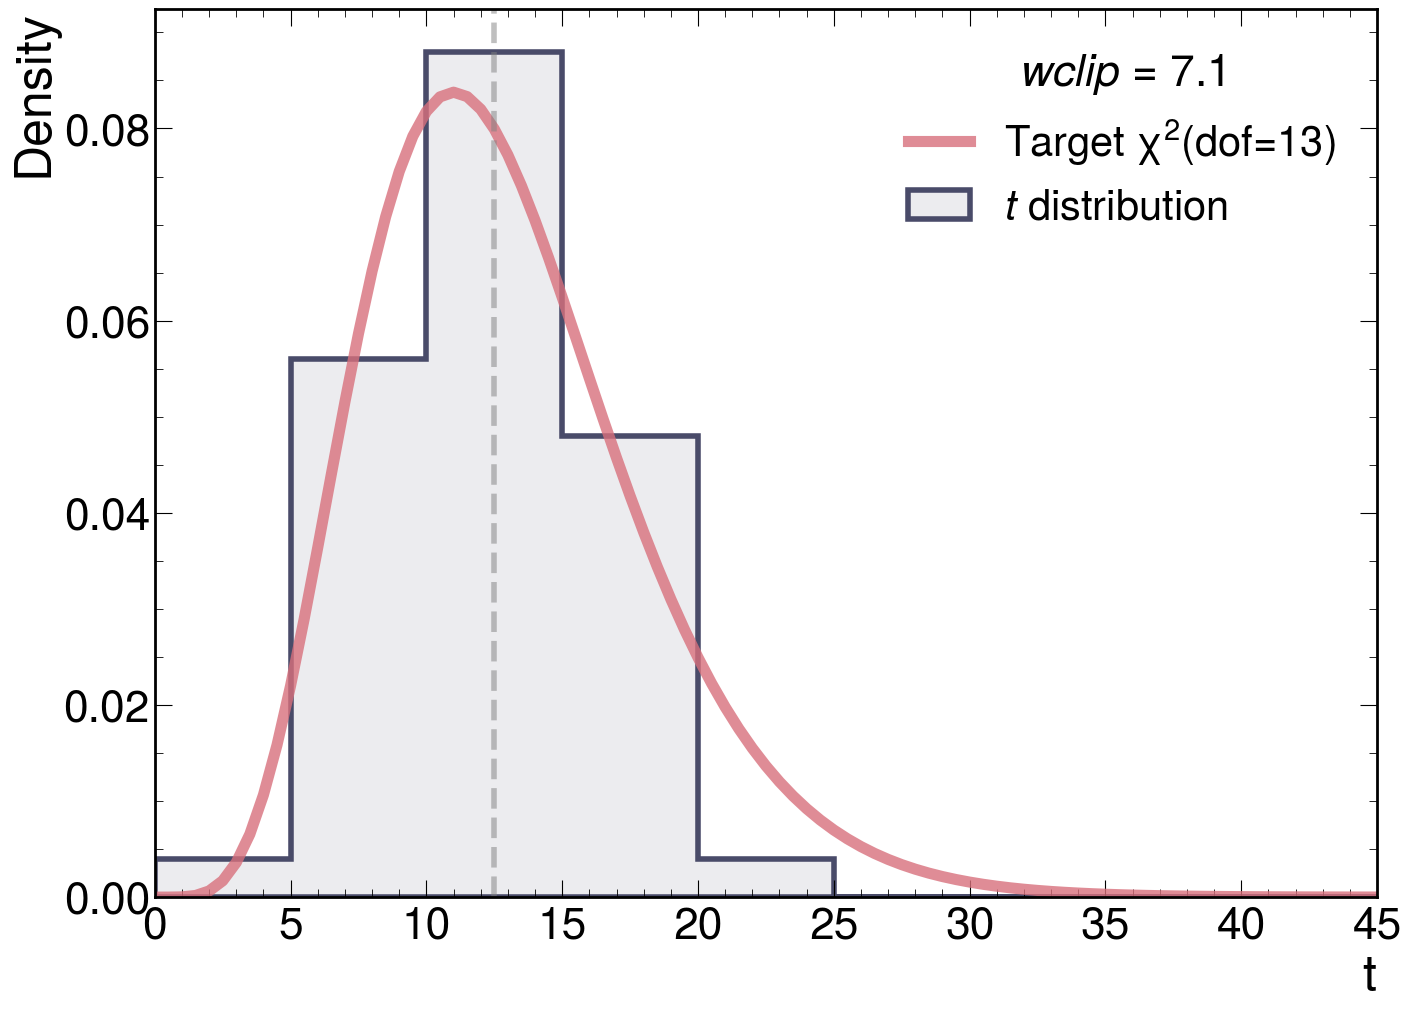

In [108]:
print(f'WEIGHT CLIPPING = {config_json_ref["weight_clipping"]}')
plot_one_t(
    t_distribution  = t_ref_final,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = FIGSIZE,
    fontsize        = FONTSIZE,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = (PALETTE_2[0], 1.0),
    hist_fcolor     = (PALETTE_2[0], 0.1),
    chi2_color      = (PALETTE_2[3], 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%i)"%(ref_dof),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = True,
    wclip           = config_json_ref["weight_clipping"],
)


### Compatibility $\mathcal{R}$ vs pseudo-$\mathcal{R}$

In [64]:
from scipy import stats
from scipy.integrate import quad
from scipy.special import erfinv

t_obs = np.median(t_ref_final)
pdf_values = ref_chi2.pdf(xgrid_ref)
# p_val_def, _ = quad(lambda x: ref_chi2.pdf(x), t_obs, np.inf)
p_val = 1 - ref_chi2.cdf(t_obs)

Z = np.sqrt(2) * erfinv(1 - p_val)

print(f'p-value: {p_val}')
print(f'Z-score: {Z}\n')

cdf_values  = ref_chi2.cdf(xgrid_ref)
cdf_t_distr = np.cumsum(t_ref_final)

ks_statistic, ks_p_value = stats.kstest(t_ref_final, "chi2", args=(13,))

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

p-value: 0.4955004687635086
Z-score: 0.6815864761861116

KS Statistic: 0.08276979520504191
P-value: 0.8551336683110273


### Plot BKG and BKG+SIG test statistics distributions

In [53]:
plot_two_t(
    t_distribution_1  = t_ref_final,
    t_bins_1          = t_ref_bins,
    t_distribution_2  = t_data_final,
    t_bins_2          = t_data_bins,
    chi2              = ref_chi2,
    chi2_grid         = xgrid_ref,
    show_error_1      = False,
    show_error_2      = False,
    show_hist_1       = True,
    show_hist_2       = True,
    compute_rate_1    = False,
    compute_rate_2    = True,
    err_marker_1      = "o",
    err_marker_2      = "o",
    err_markersize_1  = 10,
    err_markersize_2  = 10,
    err_capsize_1     = 5,
    err_capsize_2     = 5,
    err_elinewidth_1  = 4,
    err_elinewidth_2  = 4,
    err_capthick_1    = 4,
    err_capthick_2    = 4,
    figsize           = FIGSIZE,
    fontsize          = FONTSIZE,
    cms               = False,
    cms_label         = "",
    cms_rlabel        = "",
    hist_ecolor_1     = (PALETTE_2[0], 1),
    hist_ecolor_2     = (PALETTE_2[3], 1),
    hist_fcolor_1     = (PALETTE_2[0], 0.1),
    hist_fcolor_2     = (PALETTE_2[3], 0),
    err_ecolor_1      = (PALETTE_2[0], 1),
    err_ecolor_2      = (PALETTE_2[3], 1),
    chi2_color        = (PALETTE_2[0], 0.8),
    hist_lw_1         = 4,
    hist_lw_2         = 4,
    chi2_lw           = 8,
    hist_type_1       = "stepfilled",
    hist_type_2       = "stepfilled",
    hist_label_1      = "Reference $\it{t}$ distribution",
    hist_label_2      = "Observed $\it{t}$ distribution",
    chi2_label        = "Target $\chi^2$(dof=%i)"%(ref_dof),
    xlabel            = "$\it{t}$",
    ylabel            = "Density",
    show_plot         = True,
    save_plot         = False,
    plot_name         = "t_distribution",
    plot_path         = PLOT_PATH,
    plot_format       = "png",
    return_fig        = False
)

NameError: name 't_data_final' is not defined

### Plot quantiles evolution over training

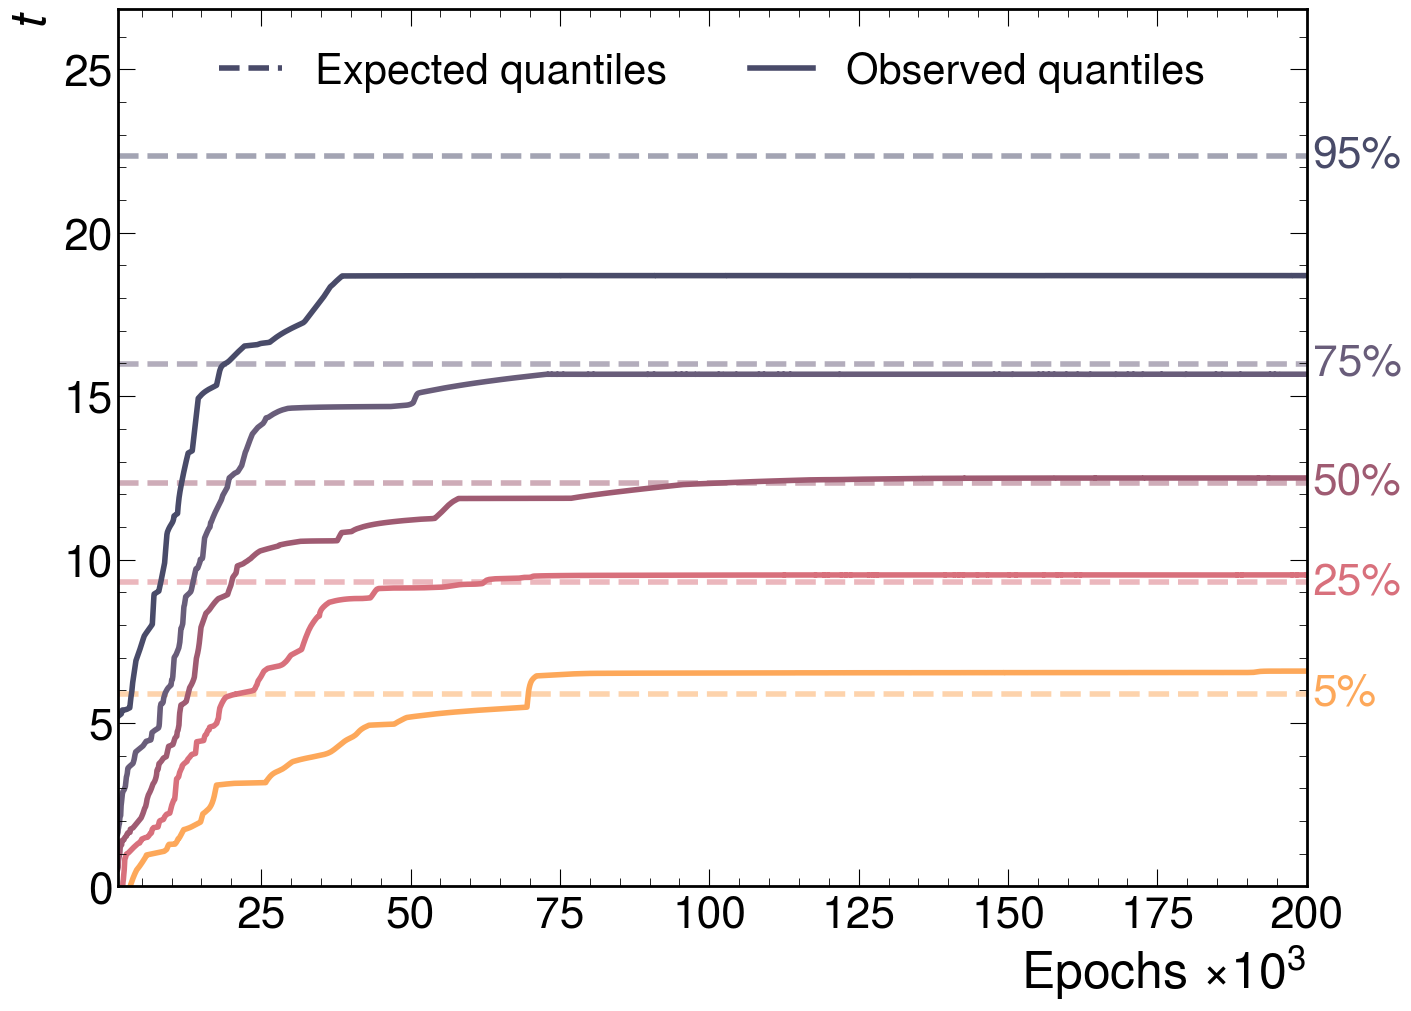

In [109]:
quantile_list   = [0.95,  0.75,  0.5,   0.25,  0.05]
quantile_labels = ["95%", "75%", "50%", "25%", "5%"]

plot_quantiles_evolution(
    t_history       = t_ref,
    quantile_list   = quantile_list,
    quantile_labels = quantile_labels,
    chi2            = ref_chi2,
    obs_alpha       = 1.0,
    th_alpha        = 0.5,
    epochs_init     = 1000,
    epochs_norm     = 1e3,
    figsize         = FIGSIZE,
    fontsize        = FONTSIZE,
    palette         = PALETTE_2,
    lw              = 4,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    grid            = False,
    xlabel          = r"Epochs $\times 10^3$",
    ylabel          = "$\it{t}$",
    show_plot       = True,
    save_plot       = True,
    plot_name       = "loss_history_w" + str({config_json_ref["weight_clipping"]}),
    plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    # plot_w          = True,
    # wclip           = config_json_ref["weight_clipping"],
)

### Compatibility $\mathcal{R}$ vs $\mathcal{D}$

In [24]:
from scipy import stats
from scipy.integrate import quad
from scipy.special import erfinv

t_obs = np.median(t_data_final)
pdf_values = ref_chi2.pdf(xgrid_ref)
p_val_def, _ = quad(lambda x: ref_chi2.pdf(x), t_obs, np.inf)
p_val = 1 - ref_chi2.cdf(t_obs)

print(p_val_def)
print(p_val)

Z = np.sqrt(2) * erfinv(1 - p_val)

print(f'p-value: {p_val}')
print(f'Z-score: {Z}')

In [25]:
# value of t which is the quantile of 95%
np.quantile(t_data_final, (1-p_val))


# w clipping 

In [136]:
results = find_results("/home/ubuntu/NPLM.torch/output/1D_w/third/1D/", ".json")
p = "/home/ubuntu/NPLM.torch/output/1D_w/first/"
results = []
for folder in os.listdir(p):
    for ff in os.listdir(p+folder):
        for j in os.listdir(p+folder+"/"+ff):
            if j.endswith(".json"):
                results.append(p+folder+"/"+ff+"/"+j)

paths = results

ref_dirs= []; ref_losses_list=[]; ref_weights_list = []; t_ref_distrib = []
w_clips = []

for path in paths:
    with open(path) as f:
        config_json_ref = json.load(f)
        ref_dirs.append(config_json_ref["output_directory"])
        w_clips.append(config_json_ref["weight_clipping"])

ref_losses_names   = find_results(ref_dirs[0], "losses.pth")
ref_weights_names  = find_results(ref_dirs[0], "weights.pth")

data = list(zip(w_clips, ref_dirs))
sorted_data = sorted(data, key=lambda tup: tup[0])
w_clips, ref_dirs = zip(*sorted_data)

for dir in ref_dirs:
    l, w = load_results(dir, ref_losses_names, ref_weights_names)
    ref_losses_list.append(compute_t_from_loss(l[:,-1]))
    ref_weights_list.append(w)    

# print("number of w clipping values: ", len(ref_losses_list))
# print("number of toys per value: ", len(ref_losses_list[0]))
# print("number of epochs, i.e. number of loss values(t): ", len(ref_losses_list[0][0]), "\n")

# for t in ref_losses_list:
#     t_ref_distrib.append(t[:,-1])

for w in range(len(w_clips)):
    ks_statistic, ks_p_value = stats.kstest(ref_losses_list[w], "chi2", args=(13,))
    
    print(f"KS Statistic for w={w_clips[w]} is : {ks_statistic}")
    print(f"P-value: {ks_p_value}\n")
    

KS Statistic for w=5.0 is : 0.1288337370197361
P-value: 0.9373570651433869

KS Statistic for w=10.0 is : 0.31112140001762656
P-value: 0.08685944267358203

KS Statistic for w=15.0 is : 0.3391160658925065
P-value: 0.048367804652461044

KS Statistic for w=20.0 is : 0.36739623469555377
P-value: 0.02532185695658906

KS Statistic for w=25.0 is : 0.19666354623013926
P-value: 0.5431161015535624

KS Statistic for w=30.0 is : 0.12807332937053728
P-value: 0.940001646122463



In [132]:
paths

['/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.1_Arch_1_4_1/2024_1_31_14_29_9_634113/config_2024_1_31_14_29_9_634113.json',
 '/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_7.0_Arch_1_4_1/2024_1_31_11_20_32_382369/config_2024_1_31_11_20_32_382369.json',
 '/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.6_Arch_1_4_1/2024_1_31_14_27_5_610308/config_2024_1_31_14_27_5_610308.json',
 '/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.8_Arch_1_4_1/2024_1_31_20_36_48_921900/config_2024_1_31_20_36_48_921900.json',
 '/home/ubuntu/NPLM.torch/output/1D_w/third/1D/NRef_200000_NBkg_2000_NSig_0_SigLoc_6.4_SigStd_0.16_Epochs_200000_Patience_5000_WClip_6.9_Arch_1_4_1/

### Second search

In [126]:
paths = find_results("/home/ubuntu/NPLM.torch/output/1D_w/second/1D/", ".json")

p = "/home/ubuntu/NPLM.torch/output/1D_w/second/1D/"
results = []
for folder in os.listdir(p):
    for ff in os.listdir(p+folder):
        for j in os.listdir(p+folder+"/"+ff):
            if j.endswith(".json"):
                results.append(p+folder+"/"+ff+"/"+j)

paths = results

ref_dirs= []; ref_losses_list=[]; ref_weights_list = []; t_ref_distrib = []
w_clips = []

for path in paths:
    with open(path) as f:
        config_json_ref = json.load(f)
        ref_dirs.append(config_json_ref["output_directory"])
        w_clips.append(config_json_ref["weight_clipping"])

ref_losses_names   = find_results(ref_dirs[0], "losses.pth")
ref_weights_names  = find_results(ref_dirs[0], "weights.pth")

data = list(zip(w_clips, ref_dirs))
sorted_data = sorted(data, key=lambda tup: tup[0])
w_clips, ref_dirs = zip(*sorted_data)

for dir in ref_dirs:
    l, w = load_results(dir, ref_losses_names, ref_weights_names)
    ref_losses_list.append(compute_t_from_loss(l))
    ref_weights_list.append(w)    

print("number of w clipping values: ", len(ref_losses_list))
print("number of toys per value: ", len(ref_losses_list[0]))
print("number of epochs, i.e. number of loss values(t): ", len(ref_losses_list[0][0]), "\n")

for t in ref_losses_list:
    t_ref_distrib.append(t[:,-1])

for w in range(len(w_clips)):
    ks_statistic, ks_p_value = stats.kstest(t_ref_distrib[w], "chi2", args=(13,))
    print(f"KS Statistic for w={w_clips[w]} is : {ks_statistic}")
    print(f"P-value: {ks_p_value}\n")
    

number of w clipping values:  17
number of toys per value:  40
number of epochs, i.e. number of loss values(t):  200000 

KS Statistic for w=4.0 is : 0.18500575394854596
P-value: 0.11358711532503152

KS Statistic for w=4.5 is : 0.1770267818957182
P-value: 0.14418481903620795

KS Statistic for w=5.0 is : 0.11537012270388958
P-value: 0.6200292359223538

KS Statistic for w=5.5 is : 0.11802362726245752
P-value: 0.5917815013295727

KS Statistic for w=6.0 is : 0.09001088928260637
P-value: 0.8733666385558663

KS Statistic for w=6.5 is : 0.12025799629324438
P-value: 0.5682201035289027

KS Statistic for w=7.0 is : 0.07621034987522142
P-value: 0.9605210778163993

KS Statistic for w=7.5 is : 0.1618646242045514
P-value: 0.22023248981276633

KS Statistic for w=8.0 is : 0.24786536151015426
P-value: 0.011903503854026165

KS Statistic for w=8.5 is : 0.13779569111549433
P-value: 0.39715881857374213

KS Statistic for w=9.0 is : 0.11835533578952345
P-value: 0.5882685907911285

KS Statistic for w=29.0 is 

Text(0, 1, 'KS compatibility')

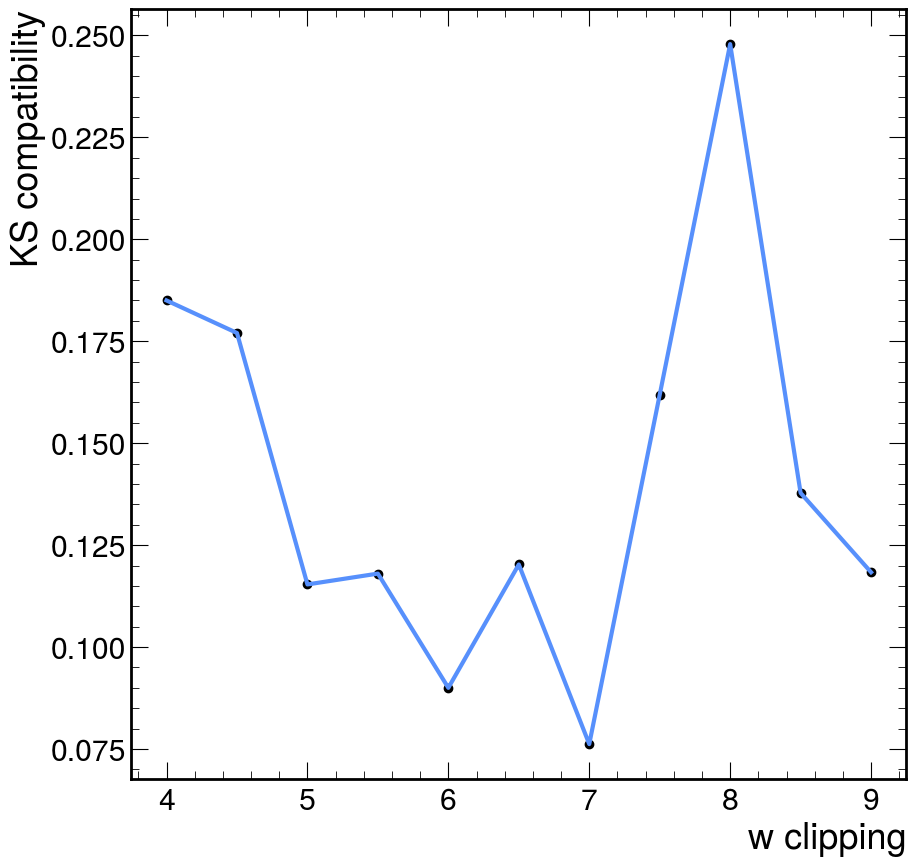

In [76]:
ks_stat = []
for i in range(len(w_clips)):
    if(w_clips[i]<10):
        ks_statistic, ks_p_value = stats.kstest(t_ref_distrib[i], "chi2", args=(13,))
        ks_stat.append(ks_statistic)
        
        
plt.scatter([w for w in w_clips if w<10], ks_stat, color='black')
plt.plot([w for w in w_clips if w<10], ks_stat, lw=3)
plt.xlabel('w clipping')
plt.ylabel('KS compatibility')

### last grid search for the best w clipping value
looking for a minimum for w clipping values between 6.5 and 7.5

In [127]:
results = find_results("/home/ubuntu/NPLM.torch/output/1D_w/third/1D/", ".json")
p = "/home/ubuntu/NPLM.torch/output/1D_w/third/1D/"
json_file = []
for folder in os.listdir(p):
    for ff in os.listdir(p+folder):
        for j in os.listdir(p+folder+"/"+ff):
            if j.endswith(".json"):
                json_file.append(p+folder+"/"+ff+"/"+j)

paths = json_file

ref_dirs= []; ref_losses_list=[]; ref_weights_list = []; t_ref_distrib = []
w_clips = []

for path in paths:
    with open(path) as f:
        config_json_ref = json.load(f)
        ref_dirs.append(config_json_ref["output_directory"])
        w_clips.append(config_json_ref["weight_clipping"])

data = list(zip(w_clips, ref_dirs))
sorted_data = sorted(data, key=lambda tup: tup[0])
w_clips, ref_dirs = zip(*sorted_data)

ref_losses_names   = find_results(ref_dirs[0], "losses.pth")
ref_weights_names  = find_results(ref_dirs[0], "weights.pth")

for dir in ref_dirs:
    l, w = load_results(dir, ref_losses_names, ref_weights_names)
    ref_losses_list.append(compute_t_from_loss(l))
    ref_weights_list.append(w)    

print("number of w clipping values: ", len(ref_losses_list))
print("number of toys per value: ", len(ref_losses_list[0]))
print("number of epochs, i.e. number of loss values(t): ", len(ref_losses_list[0][0]), "\n")

for t in ref_losses_list:
    t_ref_distrib.append(t[:,-1])

for w in range(len(w_clips)):
    ks_statistic, ks_p_value = stats.kstest(t_ref_distrib[w], "chi2", args=(13,))
    print(f"KS Statistic for w={w_clips[w]} is : {ks_statistic}")
    print(f"P-value: {ks_p_value}\n")
    

number of w clipping values:  9
number of toys per value:  50
number of epochs, i.e. number of loss values(t):  200000 

KS Statistic for w=6.5 is : 0.10701663986352672
P-value: 0.5787081447535609

KS Statistic for w=6.6 is : 0.21662773021595905
P-value: 0.015381099754653516

KS Statistic for w=6.7 is : 0.13457710931427747
P-value: 0.2981143751259817

KS Statistic for w=6.8 is : 0.08939892183138354
P-value: 0.7859603518113266

KS Statistic for w=6.9 is : 0.09818325354057722
P-value: 0.684029330916142

KS Statistic for w=7.0 is : 0.1537309416067476
P-value: 0.16937552947969492

KS Statistic for w=7.1 is : 0.08666326296638704
P-value: 0.8156323089229263

KS Statistic for w=7.2 is : 0.11583823049904118
P-value: 0.4781687681578708

KS Statistic for w=7.3 is : 0.08276979520504191
P-value: 0.8551336683110273



Text(0, 1, 'KS compatibility')

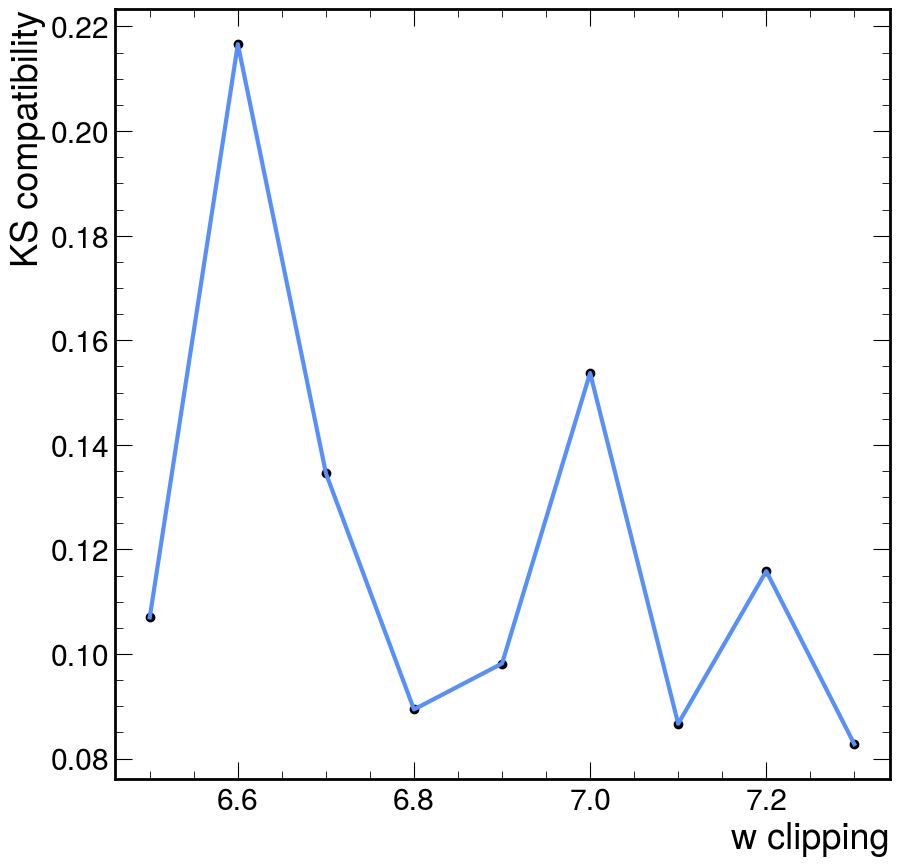

In [130]:
ks_stat = []; p_ks=[]
for i in range(len(w_clips)):
    if(w_clips[i]<10):
        ks_statistic, ks_p_value = stats.kstest(t_ref_distrib[i], "chi2", args=(13,))
        ks_stat.append(ks_statistic)
        p_ks.append(ks_p_value)
        
        
plt.scatter(w_clips, ks_stat, color='black')
plt.plot([w for w in w_clips if w<10], ks_stat, lw=3)
plt.xlabel('w clipping')
plt.ylabel('KS compatibility')